## Introducing Node2Vec

Node2Vec was introduced in 2016 by **Grover and Leskovec** from **Stanford University** [1].  
It keeps the same two main components from **DeepWalk**: *random walks* and *Word2Vec*.  
The difference is that instead of obtaining sequences of nodes with a **uniform distribution**, the random walks are **carefully biased** in Node2Vec.

We will see why these **biased random walks** perform better and how to implement them in the two following sections:

- **Defining a neighborhood**
- **Introducing biases in random walks**



### Defining a neighborhood

How do you define the neighborhood of a node?  
The key concept introduced in **Node2Vec** is the **flexible notion of a neighborhood**.  
Intuitively, we think of it as something close to the initial node,  
but what does “close” mean in the context of a graph?

Let’s take the following graph as an example:


<p align="center">
  <img src="images/1.jpg" width="400">
</p>


We want to explore three nodes in the neighborhood of node **A**. This exploration process is also called  
a **sampling strategy**:

- A possible solution would be to consider the three closest nodes in terms of connections.  
  In this case, the neighborhood of **A**, noted **N(A)**, would be:  
  **N(A) = {B, C, D}**

- Another possible sampling strategy consists of selecting nodes that are not adjacent to previous nodes first.  
  In our example, the neighborhood of **A** would be:  
  **N(A) = {D, E, F}**

In other words, we want to implement a **Breadth-First Search (BFS)** in the first case and a  
**Depth-First Search (DFS)** in the second one.  




What is important to notice here is that these sampling strategies have **opposite behaviors**:  
- **BFS** focuses on the local network around a node  
- while **DFS** establishes a more macro view of the graph.

Considering our intuitive definition of a neighborhood, it is tempting to simply discard **DFS**.  
However, the authors of **Node2Vec** argue that this would be a **mistake**:  
> Each approach captures a different but valuable representation of the network.


### Introducing biases in random walks

As a reminder, random walks are sequences of nodes that are randomly selected in a graph.  
They have a starting point, which can also be random, and a predefined length.  
Nodes that often appear together in these walks are like words that appear together in sentences:  
under the homophily hypothesis, they share a similar meaning, hence a similar representation.

---

### Improving Embeddings with Biased Random Walks in Node2Vec

In **Node2Vec**, our goal is to bias the randomness of these walks to either one of the following:

- Promoting nodes that are not connected to the previous one (similar to DFS)
- Promoting nodes that are close to the previous one (similar to BFS)

<p align="center">
  <img src="images/2.jpg" width="400">
</p>

 The current node is called **j**, the previous node is **i**, and the future node is **k**.  
We note **π<sub>jk</sub>**, the unnormalized transition probability from node **j** to node **k**.  
This probability can be decomposed as:

$$
\pi_{jk} = \alpha(i, k) \cdot \omega_{jk}
$$

where **α(i, k)** is the *search bias* between nodes **i** and **k**, and **ω<sub>jk</sub>** is the weight of the edge from **j** to **k**.

In **DeepWalk**, we have:

$$
\alpha(a, b) = 1
$$

for any pair of nodes **a** and **b**.  

In **Node2Vec**, the value of **α(a, b)** is defined based on the distance between the nodes and two additional parameters:  
- **p**, the return parameter  
- **q**, the in-out parameter  

Their role is to approximate **DFS** and **BFS**, respectively.


In **DeepWalk**, we have **α(a, b) = 1** for any pair of nodes **a** and **b**.  
In **Node2Vec**, the value of **α(a, b)** is defined based on the distance between the nodes and two additional parameters:  
- **p**, the return parameter, and  
- **q**, the in-out parameter.

Their role is to approximate **DFS** and **BFS**, respectively.



### Definition of α(a, b):

$$
\alpha(a, b) = 
\begin{cases}
\frac{1}{p} & \text{if } d_{ab} = 0 \\\\
1           & \text{if } d_{ab} = 1 \\\\
\frac{1}{q} & \text{if } d_{ab} = 2
\end{cases}
$$

Here, **d<sub>ab</sub>** is the shortest path distance between nodes **a** and **b**.



We can update the unnormalized transition probability from the previous graph as follows:

<p align="center">
  <img src="images/3.jpg" width="400">
</p>

- Transition back to **i**: weight = **1/p**  
- Transition to **k₁**: weight = **1**  
- Transition to **k₂**: weight = **1/q**


> When we say that $d_{ab} = 0$, it means that the node at time step $n+1$ is the same as the node at time step $n-1$.


### 🔍 Understanding the Meaning of These Probabilities

Let’s break down what each probability means:

- ✅ **The walk starts from node `i` and now arrives at node `j`.**  
  The probability of going back to the previous node `i` is controlled by the parameter **`p`**.  
  The **higher** the value of `p`, the **less likely** the walk is to go back — instead, it prefers exploring new nodes.  
  This makes the walk behave more like a **Depth-First Search (DFS)**.

- ✅ **The unnormalized probability of going to node `k₁` is 1**  
  because `k₁` is in the **immediate neighborhood** of the previous node `i`.  
  There’s no penalty or boost applied here — it’s treated as a neutral move.

- ✅ **The probability of going to node `k₂` is controlled by parameter `q`.**  
  The **higher** the value of `q`, the **less likely** the walk will explore distant nodes.  
  Instead, it prefers staying **close** to the previous node — just like in a **Breadth-First Search (BFS)**.



### 💡 Summary:

- Use **high `p`** to discourage returning to previous nodes (promotes DFS-style exploration).
- Use **high `q`** to discourage walking to distant nodes (promotes BFS-style exploration).

---

### 🔧 Next Step:

The best way to understand this behavior is to **implement** the algorithm and **experiment** with the values of `p` and `q`.

Let’s do this step by step on following graph:


In [6]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

/home/mohammadjavad/anaconda3/envs/py312/lib/python3.12/site-packages/networkx/drawing/nx_pylab.py:457: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


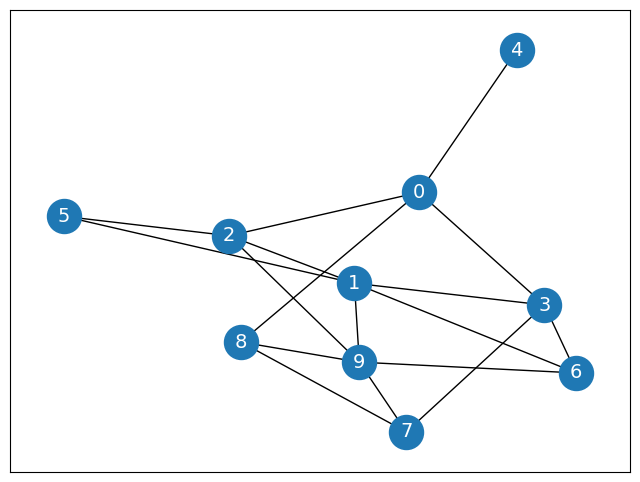

In [5]:
G = nx.erdos_renyi_graph(10, 0.3, seed=42, directed=False)

pos = nx.spring_layout(G, seed=42)
plt.figure(figsize=(8, 6))
nx.draw_networkx(G,
                 pos=pos,
                 node_size=600,
                 cmap='coolwarm',
                 font_size=14,
                 font_color='white'                
                 )

First, we want to create a function that will randomly select the next node in a graph based on the
previous node, the current node, and the two parameters and .

In [7]:
import random
random.seed(42)
np.random.seed(42)

In [21]:
def next_node(graph, previous, current, p, q):
    alphas = []

    neighbors = list(graph.neighbors(current))
    for neighbor in neighbors:
        if neighbor == previous:
            alpha = 1 / p
        elif graph.has_edge(previous, neighbor):
            alpha = 1
        else:
            alpha = 1 / q
        alphas.append(alpha)

    probs = [alpha / sum(alphas) for alpha in alphas]  # Normalize the alpha values to create transition probabilities

    next = np.random.choice(neighbors, size=1, p=probs)[0]
    return next

In [22]:
def random_walk(graph, start, length, p, q):
    w = [start]
    previous = None
    current = start

    for i in range(length):
        next = next_node(graph=graph, previous=previous, current=current, p=p, q=q)
        w.append(next)
        previous = w[i]
        current = w[-1]
    
    return w

In [23]:
random_walk(graph=G, start=1, length=10, p=1, q=1)

[1, 9, 7, 8, 0, 2, 0, 8, 7, 9, 1]

In [29]:
random_walk(graph=G, start=1, length=10, p=1000, q=0.5)

[1, 3, 7, 8, 0, 3, 1, 9, 2, 5, 1]

In [30]:
random_walk(graph=G, start=1, length=10, p=0.5, q=1000)

[1, 2, 1, 9, 2, 9, 2, 1, 2, 1, 9]